In [1]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

2024-08-06 18:50:39.012507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 18:50:39.012551: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 18:50:39.012572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 18:50:39.018350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 18:50:40.274934: W tensorflow/compiler/

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys
import matplotlib.colors as mcolors

all_cmaps = []

def get_alpha_cmap(rgb_color):
    # Normalize the RGB color values to the range [0, 1]
    rgb_color = np.array(rgb_color) / 255.0

    # Create an alpha colormap with varying alpha values
    cmap_data = {'red':   [(0, rgb_color[0], rgb_color[0]),
                           (1, rgb_color[0], rgb_color[0])],
                 'green': [(0, rgb_color[1], rgb_color[1]),
                           (1, rgb_color[1], rgb_color[1])],
                 'blue':  [(0, rgb_color[2], rgb_color[2]),
                           (1, rgb_color[2], rgb_color[2])],
                 'alpha': [(0, 0, 0),
                           (1, 1, 1)]}

    alpha_cmap = mcolors.LinearSegmentedColormap('alpha_cmap', cmap_data, N=256)

    all_cmaps.append(alpha_cmap)

    return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

c1 = get_alpha_cmap((33, 115, 174))
c2 = get_alpha_cmap((216, 146, 49))
c3 = get_alpha_cmap((58, 155, 118))
c4 = get_alpha_cmap((210, 158, 201))

In [3]:
baseline_to_color = {
'zero' : anthracite,
'uniform' : c1,
'normal' : c1,
'permutation' : c1,
'local_permutation' : c2,
'local_mean' : c2,
'mean' : c3,
'median' : c3,
'random_color' : anthracite,
'scramble_phase' : c4,
'scramble_amplitude' : c4,
'fv': slack_red,
'ROAD': google_green
}

baseline_to_linestyle = {
'zero' : 'o',
'uniform' : 'o',
'normal' : '^',
'permutation' : 'o',
'local_permutation' : '^',
'local_mean' : 'o',
'mean' : '^',
'median' : 's',
'random_color' : '^',
'scramble_phase' : 'o',
'scramble_amplitude' : '^',
'fv': '*',
'ROAD': 'o'
}

baseline_to_lstyle = {
'zero' : '-',
'uniform' : '-',
'normal' : '--',
'permutation' : '-',
'local_permutation' : '--',
'local_mean' : '-',
'mean' : '--',
'median' : ':',
'random_color' : '--',
'scramble_phase' : '-',
'scramble_amplitude' : '--',
'fv': ':',
'ROAD': '-'
}

## Define the baselines

In [4]:
from xplique.attributions import *
from xplique.metrics import *

In [5]:
def permute_ax1(x):
  x = x.copy()
  x = np.moveaxis(x, 1, 0)
  np.random.shuffle(x)
  x = np.moveaxis(x, 1, 0)
  return x

def random_permute(x):
  x = np.array(x).copy()
  s = x.shape
  x = x.reshape((len(x), -1, 3))
  x = permute_ax1(x)
  return x.reshape(s)

def downsample_upsample(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = tf.image.resize(x, s, method="nearest")
  return x

def local_permute(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = random_permute(x)
  x = tf.image.resize(x, s, method="nearest")
  return x

def scramble_phase(x):
  spectrum = np.fft.fft2(x)
  amplitude = np.abs(spectrum)

  phase = np.angle(spectrum)
  phase = random_permute(phase)
  #phase = np.random.normal(phase.mean(), phase.std(), phase.shape)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x

def scramble_amplitude(x):
  spectrum = np.fft.fft2(x)

  amplitude = np.abs(spectrum)
  amplitude = random_permute(amplitude)

  phase = np.angle(spectrum)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x


baselines = {
    'zero': lambda x : tf.zeros(x.shape),
    'uniform': lambda x : tf.random.uniform(x.shape, -1, 1),
    'normal': lambda x : tf.clip_by_value(tf.random.normal(x.shape), -1, 1),
    'permutation': lambda x : random_permute(x),
    'local_mean': lambda x : downsample_upsample(x),
    'local_permutation': lambda x : local_permute(x),
    'mean': lambda x : np.ones(x.shape) * np.mean(x, (1, 2))[:, None, None, :],
    'median': lambda x : np.ones(x.shape) * np.median(x, (1, 2))[:, None, None, :],
    'random_color': lambda x : np.ones(x.shape) * (np.random.rand(3) * 2 - 1.),
    'scramble_phase': lambda x : scramble_phase(x),
    'scramble_amplitude': lambda x : scramble_amplitude(x)
}

In [6]:
# Implementations of our imputation models.
import torch
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve

class BaseImputer():
    def __call__(self, img: torch.Tensor, mask: torch.Tensor)-> torch.Tensor:
        """ Call the Imputation function to fill the masked pixels in an image.
            :param img: original image (C,H,W)-tensor
            :param mask: (H,W)-tensor with a binary mask. 0 indicates pixels absent, 1 indicates pixels present.
            :returns: a (C,H,W) tensor, where the original values are kept, if the mask for the pixels is 1 or imputed otherwise.
            The return tensor is copied to cpu()
        """
        raise NotImplementedError("Please implement an imputation function or use an existing imputor.")

    def batched_call(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """ Call the Imputation function to fill the masked pixels in an image. However, in this version,
            and entire batch of images will be processed, which can results in considerable speedup.
            :param img: B original images (B, C, H, W)-tensor
            :param mask: (B, H, W)-tensor with binary masks. 0 indicates pixels absent, 1 indicates pixels present.
            :returns: a (B, C, H, W) tensor, where the original values are kept, if the mask for the pixels is 1 or imputed otherwise.
            The returned tensor is left on the device that this dataloader is instructed to use (may not be CPU).
        """
        raise NotImplementedError("This imputer does not support the bached interface.")

# Some Imputors
class ChannelMeanImputer(BaseImputer):
    """ Impute by the mean value per channel of the image. """

    def __call__(self, img: torch.Tensor, mask: torch.Tensor):
        for c in range(len(img)):
            mean_c = img[c,:,:].mean()
            imgsubtensor = img[c,:,:]
            imgsubtensor[mask==0] = mean_c
        return img

    def batched_call(self, img: torch.Tensor, mask: torch.Tensor):
        channel_mean_tensor = img.view(img.shape[0], img.shape[1], -1).mean(axis=2) # [B, C]
        c_shape = channel_mean_tensor.shape
        channel_mean_tensor = channel_mean_tensor.unsqueeze(2).unsqueeze(3).expand(c_shape[0], c_shape[1], img.shape[2], img.shape[3])
        return (channel_mean_tensor * (1.0-mask.unsqueeze(1))) + img*mask.unsqueeze(1)

class ZeroImputer(BaseImputer):
    def __call__(self, img: torch.Tensor, mask: torch.Tensor):
        return img*mask.unsqueeze(0)
    
    def batched_call(self, img: torch.Tensor, mask: torch.Tensor):
        assert img.device == mask.device
        return img*mask.unsqueeze(1)

# Code for infilling.
neighbors_weights = [((1,1), 1/12), ((0,1), 1/6), ((-1,1), 1/12), ((1,-1), 1/12), ((0,-1), 1/6), ((-1,-1), 1/12), ((1,0), 1/6), ((-1,0), 1/6)]

class NoisyLinearImputer(BaseImputer):
    def __init__(self, noise=0.01, weighting=neighbors_weights):
        """	
            Noisy linear imputation.	
            noise: magnitude of noise to add (absolute, set to 0 for no noise)
            weighting: Weights of the neighboring pixels in the computation. 
            List of tuples of (offset, weight)
        """
        self.noise = noise
        self.weighting = weighting
    
    @staticmethod 
    def add_offset_to_indices(indices, offset, mask_shape):
        """ Add the corresponding offset to the indices. Return new indices plus a valid bit-vector. """
        cord1 = indices % mask_shape[1]
        cord0 = indices // mask_shape[1]
        cord0 += offset[0]
        cord1 += offset[1]
        #print(cord1.shape, indices.shape)
        valid = ((cord0 < 0) | (cord1 < 0) | (cord0 >= mask_shape[0]) | (cord1 >= mask_shape[1]))
        return ~valid, indices+offset[0]*mask_shape[1]+offset[1]

    @staticmethod 
    def setup_sparse_system(mask, img, neighbors_weights):
        """ Vectorized version to set up the equation system.
            mask: (H, W)-tensor of missing pixels.
            Image: (H, W, C)-tensor of all values.
            Return (N,N)-System matrix, (N,C)-Right hand side for each of the C channels.
        """
        maskflt = mask.flatten()
        imgflat = img.reshape((img.shape[0], -1))
        #print(imgflat.shape)
        indices = np.argwhere(maskflt==0).flatten() # Indices that are imputed in the flattened mask
        coords_to_vidx= np.zeros(len(maskflt), dtype=int)
        coords_to_vidx[indices] = np.arange(len(indices)) # lookup_indices =
        #print(coords_to_vidx[:10])
        #coords_to_vidx = {(idx[0].item(), idx[1].item()): i for i, idx in enumerate(indices)} # Coordinates to variable index
        numEquations = len(indices)
        A = lil_matrix((numEquations, numEquations)) # System matrix
        b = np.zeros((numEquations, img.shape[0]))
        sum_neighbors = np.ones(numEquations) # Sum of weights assigned
        #print("My indices:", indices[:10])
        #print("Num indices: ", len(indices))
        for n in neighbors_weights:
            offset, weight = n[0], n[1]
            #print("Using: ", offset, weight)
            # Sum of the neighbors.
            # Take out outliers
            valid, new_coords = NoisyLinearImputer.add_offset_to_indices(indices, offset, mask.shape)
            
            valid_coords = new_coords[valid]
            valid_ids = np.argwhere(valid==1).flatten()
            #print(valid_ids[:10], valid_coords[:10])
            #print("Valid:", valid_ids.shape)
            
            # Add values to the right hand-side
            has_values_coords = valid_coords[maskflt[valid_coords] > 0.5]
            has_values_ids = valid_ids[maskflt[valid_coords] > 0.5]
            #print(has_values_ids[:10], has_values_coords[:10])
            #print("Has Values:", has_values_coords.shape)
            b[has_values_ids, :] -= weight*imgflat[:, has_values_coords].T
            
            # Add weights to the system (left hand side)
            has_no_values = valid_coords[maskflt[valid_coords] < 0.5] # Find coordinates in the system.
            variable_ids = coords_to_vidx[has_no_values]
            has_no_values_ids = valid_ids[maskflt[valid_coords] < 0.5]
            
            #print("Has No Values:", has_no_values.shape)
            A[has_no_values_ids, variable_ids] = weight
            
            # Reduce weight for invalid
            #print(np.argwhere(valid==0).flatten()[:10])
            sum_neighbors[np.argwhere(valid==0).flatten()] = sum_neighbors[np.argwhere(valid==0).flatten()] - weight

        A[np.arange(numEquations),np.arange(numEquations)] = -sum_neighbors  
        return A, b

    def __call__(self, img: torch.Tensor, mask: torch.Tensor):
        """ Our linear inputation scheme. """
        """
        This is the function to do the linear infilling 
        img: original image (C,H,W)-tensor;
        mask: mask; (H,W)-tensor

        """
        imgflt = img.reshape(img.shape[0], -1)
        maskflt = mask.reshape(-1)
        indices_linear = np.argwhere(maskflt==0).flatten() # Indices that need to be imputed.
        # Set up sparse equation system, solve system.
        A, b = NoisyLinearImputer.setup_sparse_system(mask.numpy(), img.numpy(), neighbors_weights)
        res = torch.tensor(spsolve(csc_matrix(A), b), dtype=torch.float)

        # Fill the values with the solution of the system.
        img_infill = imgflt.clone()
        img_infill[:, indices_linear] = res.t() + self.noise*torch.randn_like(res.t())
            
        return img_infill.reshape_as(img).numpy()  # I added the .numpy() to interface with TF

    def batched_call(self, img: torch.Tensor, mask: torch.Tensor):
        """ Pseudo implementation of batched interface. """
        res_list = []
        in_device = img.device
        for i in range(len(img)):
            res_list.append(self.__call__(img[i].cpu(), mask[i].cpu()))
        return torch.stack(res_list).to(in_device)

In [7]:
noisy_linear_imputer = NoisyLinearImputer()

def noisy_linear_baseline(imgs, masks):
    masked_imgs = []
    for img, mask in zip(imgs, masks):
        channel_first_img = torch.tensor(np.moveaxis(img, -1, 0))
        masked_img = noisy_linear_imputer(channel_first_img, mask)
        channel_last_masked_img = np.moveaxis(masked_img, 0, -1)
        masked_imgs.append(channel_last_masked_img)
    return masked_imgs

In [8]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)
feature_model = tf.keras.Model(model.input, model.layers[-2].output)

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

2024-08-06 18:50:44.704483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 18:50:44.725729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 18:50:44.725887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
X = np.load('../imagenet_samples.npy')
X = preprocess(X)
X.shape

(200, 224, 224, 3)

In [10]:
Bank = np.load('../imagenet_samples_5000.npy')
Bank = preprocess(Bank)
Bank = feature_model.predict(Bank, batch_size=128)

2024-08-06 18:50:48.507109: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3010560000 exceeds 10% of free system memory.
2024-08-06 18:50:49.746222: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3010560000 exceeds 10% of free system memory.
2024-08-06 18:50:51.332001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


40/40 [==============================] - 5s 91ms/step


In [11]:
def generate_path(images, explanations, baseline_func, steps=10):
  images_flatten = np.array(images).reshape((len(images), -1, images.shape[-1]))

  min_img = np.min(images, (1,2,3))
  max_img = np.max(images, (1,2,3))

  if len(explanations.shape) == 4:
    explanations = np.mean(explanations, -1)

  explanations_flatten = explanations.reshape((len(explanations), -1))
  most_important_features = np.argsort(explanations_flatten, axis=-1)[:, ::-1]

  baselines = np.array(baseline_func(images))
  baselines_flatten = baselines.reshape((len(images), -1, images.shape[-1]))

  steps = np.linspace(0, baselines_flatten.shape[1], steps + 1, dtype=np.int32)

  start = images_flatten
  end = baselines_flatten

  ret = []

  for step in steps:
    ids_to_flip = most_important_features[:, :step]
    batch_inputs = start.copy()

    for i, ids in enumerate(ids_to_flip):
      batch_inputs[i, ids] = end[i, ids]

    batch_inputs = batch_inputs.reshape(images.shape)
    batch_inputs = np.clip(batch_inputs, min_img[:, None, None, None], max_img[:, None, None, None])
    ret.append(batch_inputs)

  return ret

In [12]:
H = np.load('./resnet50_GradCAM.npy')  # explanations generated using the other notebook!
H.shape

(200, 224, 224, 1)

In [13]:
def create_mask(image: torch.Tensor, values: torch.Tensor, n: int) -> torch.Tensor:
    """
    Create a binary mask from a tensor of float32 values by setting the n highest values to 0 
    and the rest to 1.

    Args:
        image (torch.Tensor): The input image tensor of shape (C, H, W).
        values (torch.Tensor): The tensor of float32 values of shape (H, W).
        n (int): The number of highest values to set to 0.

    Returns:
        torch.Tensor: The binary mask of shape (H, W) with the n highest values set to 0 and the rest to 1.
    """
    # Ensure values tensor has the same height and width as the image
    assert image.shape[1:] == values.shape, "Shape of values tensor must match the height and width of the image."

    # Flatten the values tensor and get the indices of the top n values
    flattened_values = torch.tensor(values.flatten())
    top_n_indices = torch.topk(flattened_values, n).indices

    # Create a mask of ones
    mask = torch.ones_like(flattened_values, dtype=torch.uint8)

    # Set the top n values in the mask to 0
    mask[top_n_indices] = 0

    # Reshape the mask to the original (H, W) shape
    mask = mask.reshape(values.shape)

    return mask

def generate_path_ROAD(images, explanations, n_steps=10):
    n, h, w, c = images.shape
    images_flatten = np.array(images).reshape((len(images), -1, images.shape[-1]))

    min_img = np.min(images, (1,2,3))
    max_img = np.max(images, (1,2,3))

    if len(explanations.shape) == 4:
        explanations = np.mean(explanations, -1)
        
    steps = np.linspace(0, h * w, n_steps + 1, dtype=np.int32)
    
    ret = []
    for step in steps:
        masks = [create_mask(np.moveaxis(img, -1, 0), exp, step) for img, exp in zip(images, explanations)]
        masks = torch.stack(masks, dim=0)
        masked_images = noisy_linear_baseline(images, masks)
        ret.append(masked_images)
        
    return ret

In [14]:
import cv2

baseline_fv = cv2.resize(cv2.imread('./baseline_resnet.png')[:, :,::-1], (224, 224)).astype(np.float32)
baseline_fv = (baseline_fv / 127.0) - 1.0

def apply_baseline_fv(x):
  return np.array([baseline_fv for _ in range(len(x))])

baselines['fv'] = lambda x : apply_baseline_fv(x)

## Information removal for all the baselines

In [15]:
steps = 20

RESULTS_REMOVAL = {}
for baseline_name, baseline_func in baselines.items():
  RESULTS_REMOVAL[baseline_name] = []

  chunks = generate_path(np.array(X[:len(H)]), np.array(H), baseline_func, steps=steps)
  for step_id in range(steps):
    images = chunks[step_id]
    score_removal = np.sum(tf.nn.sigmoid(model.predict(images)))
    RESULTS_REMOVAL[baseline_name].append((step_id, score_removal))

  print("done for", baseline_name)

7/7 [==============================] - 0s 23ms/step
done for zero
7/7 [==============================] - 0s 23ms/step
done for uniform
7/7 [==============================] - 0s 23ms/step
done for normal
7/7 [==============================] - 0s 24ms/step
done for permutation
7/7 [==============================] - 0s 24ms/step
done for local_mean
7/7 [==============================] - 0s 23ms/step
done for local_permutation
7/7 [==============================] - 0s 23ms/step
done for mean
7/7 [==============================] - 0s 23ms/step


7/7 [==============================] - 0s 23ms/step
done for median
7/7 [==============================] - 0s 23ms/step
done for random_color
7/7 [==============================] - 0s 24ms/step
done for scramble_phase
7/7 [==============================] - 0s 24ms/step
done for scramble_amplitude
7/7 [==============================] - 0s 24ms/step
done for fv


In [16]:
n_steps = 20

removal_road = []
chunks = generate_path_ROAD(np.array(X[:len(H)]), np.array(H), n_steps=steps)
for step_id in range(steps):
    images = chunks[step_id]
    images = tf.stack(images, axis=0)
    score_removal = np.sum(tf.nn.sigmoid(model.predict(images)))
    removal_road.append((step_id, score_removal))

print("done for", 'ROAD')

7/7 [==============================] - 0s 24ms/step
done for ROAD


In [17]:
RESULTS_REMOVAL['ROAD'] = removal_road

## Make the plot

In [18]:
results = {}

for baseline in RESULTS_REMOVAL.keys():
  removal_curve = [s/200/20 for _,s in RESULTS_REMOVAL[baseline]]
  results[baseline] = removal_curve

In [19]:
from scipy.interpolate import interp1d
import csaps

def poly_interp(points, smooth = 0.85, nb_points = 300):
  #polynom = np.polyfit(range(len(points)), points, order)
  xs = np.linspace(0, len(points)-1, nb_points)
  #f = scipy.interpolate.spline(xk, yk, xnew, order=3, kind='smoothest', conds=None)
  #f = interp1d(range(len(points)), points, kind='quadratic')
  #f = csaps.UnivariateCubicSmoothingSpline(range(len(points)), points, smooth=0.85)
  #ys = f(xs)
  ys = csaps.csaps(range(len(points)), points, xs, smooth=smooth)
  #ys = np.polyval(polynom, xs)

  return xs, ys

Text(0, 0.5, 'Mean of sigmoid')

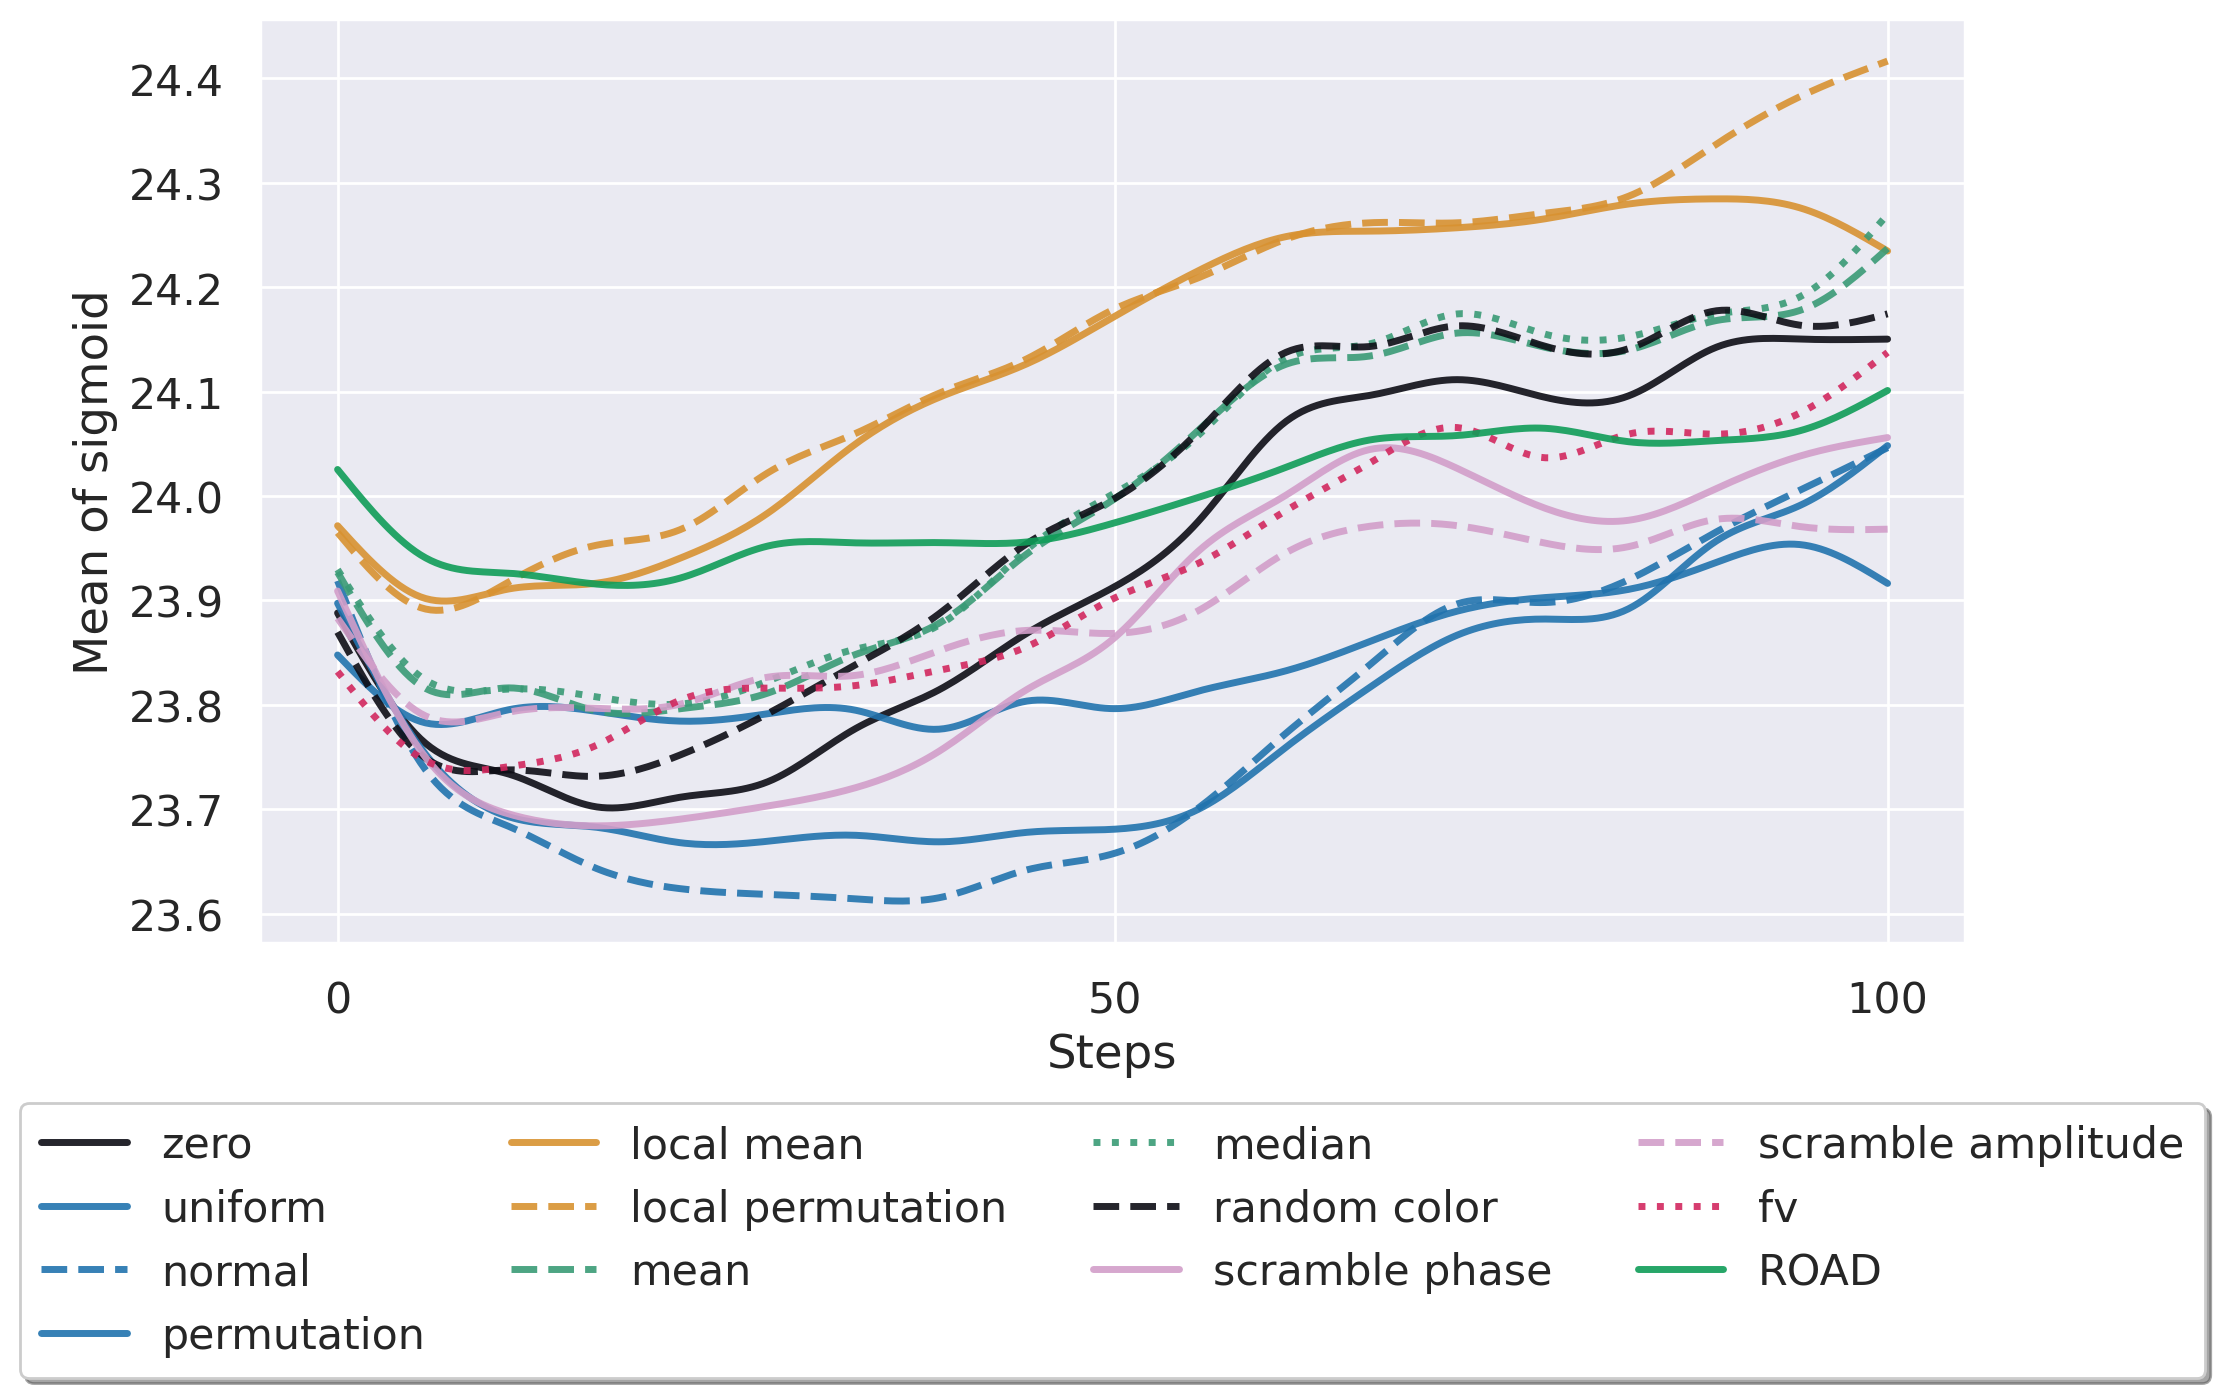

In [20]:
sns.set(font_scale=1.4)
set_size(11, 6)
cmap = plt.get_cmap('viridis')

lw = 2.5

for baseline in results:
  points = results[baseline]

  curve = [np.mean(p) for p in points][1:]
  stds = [np.std(p) for p in points][1:]

  color = baseline_to_color[baseline]
  ls = baseline_to_lstyle[baseline]

  xs, ys = poly_interp(curve, smooth=1.0)

  #plt.plot(curve, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)
  plt.plot(xs, ys, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.9, linestyle=ls)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')
plt.xticks([0, xs[len(xs)//2], xs[-1]], [0, 50, 100])
plt.xlabel("Steps")
plt.ylabel('Mean of sigmoid')
# plt.savefig('removal_resnet.png', dpi=400, transparent=True)
#plt.title()

Text(0, 0.5, 'Std of sigmoid')

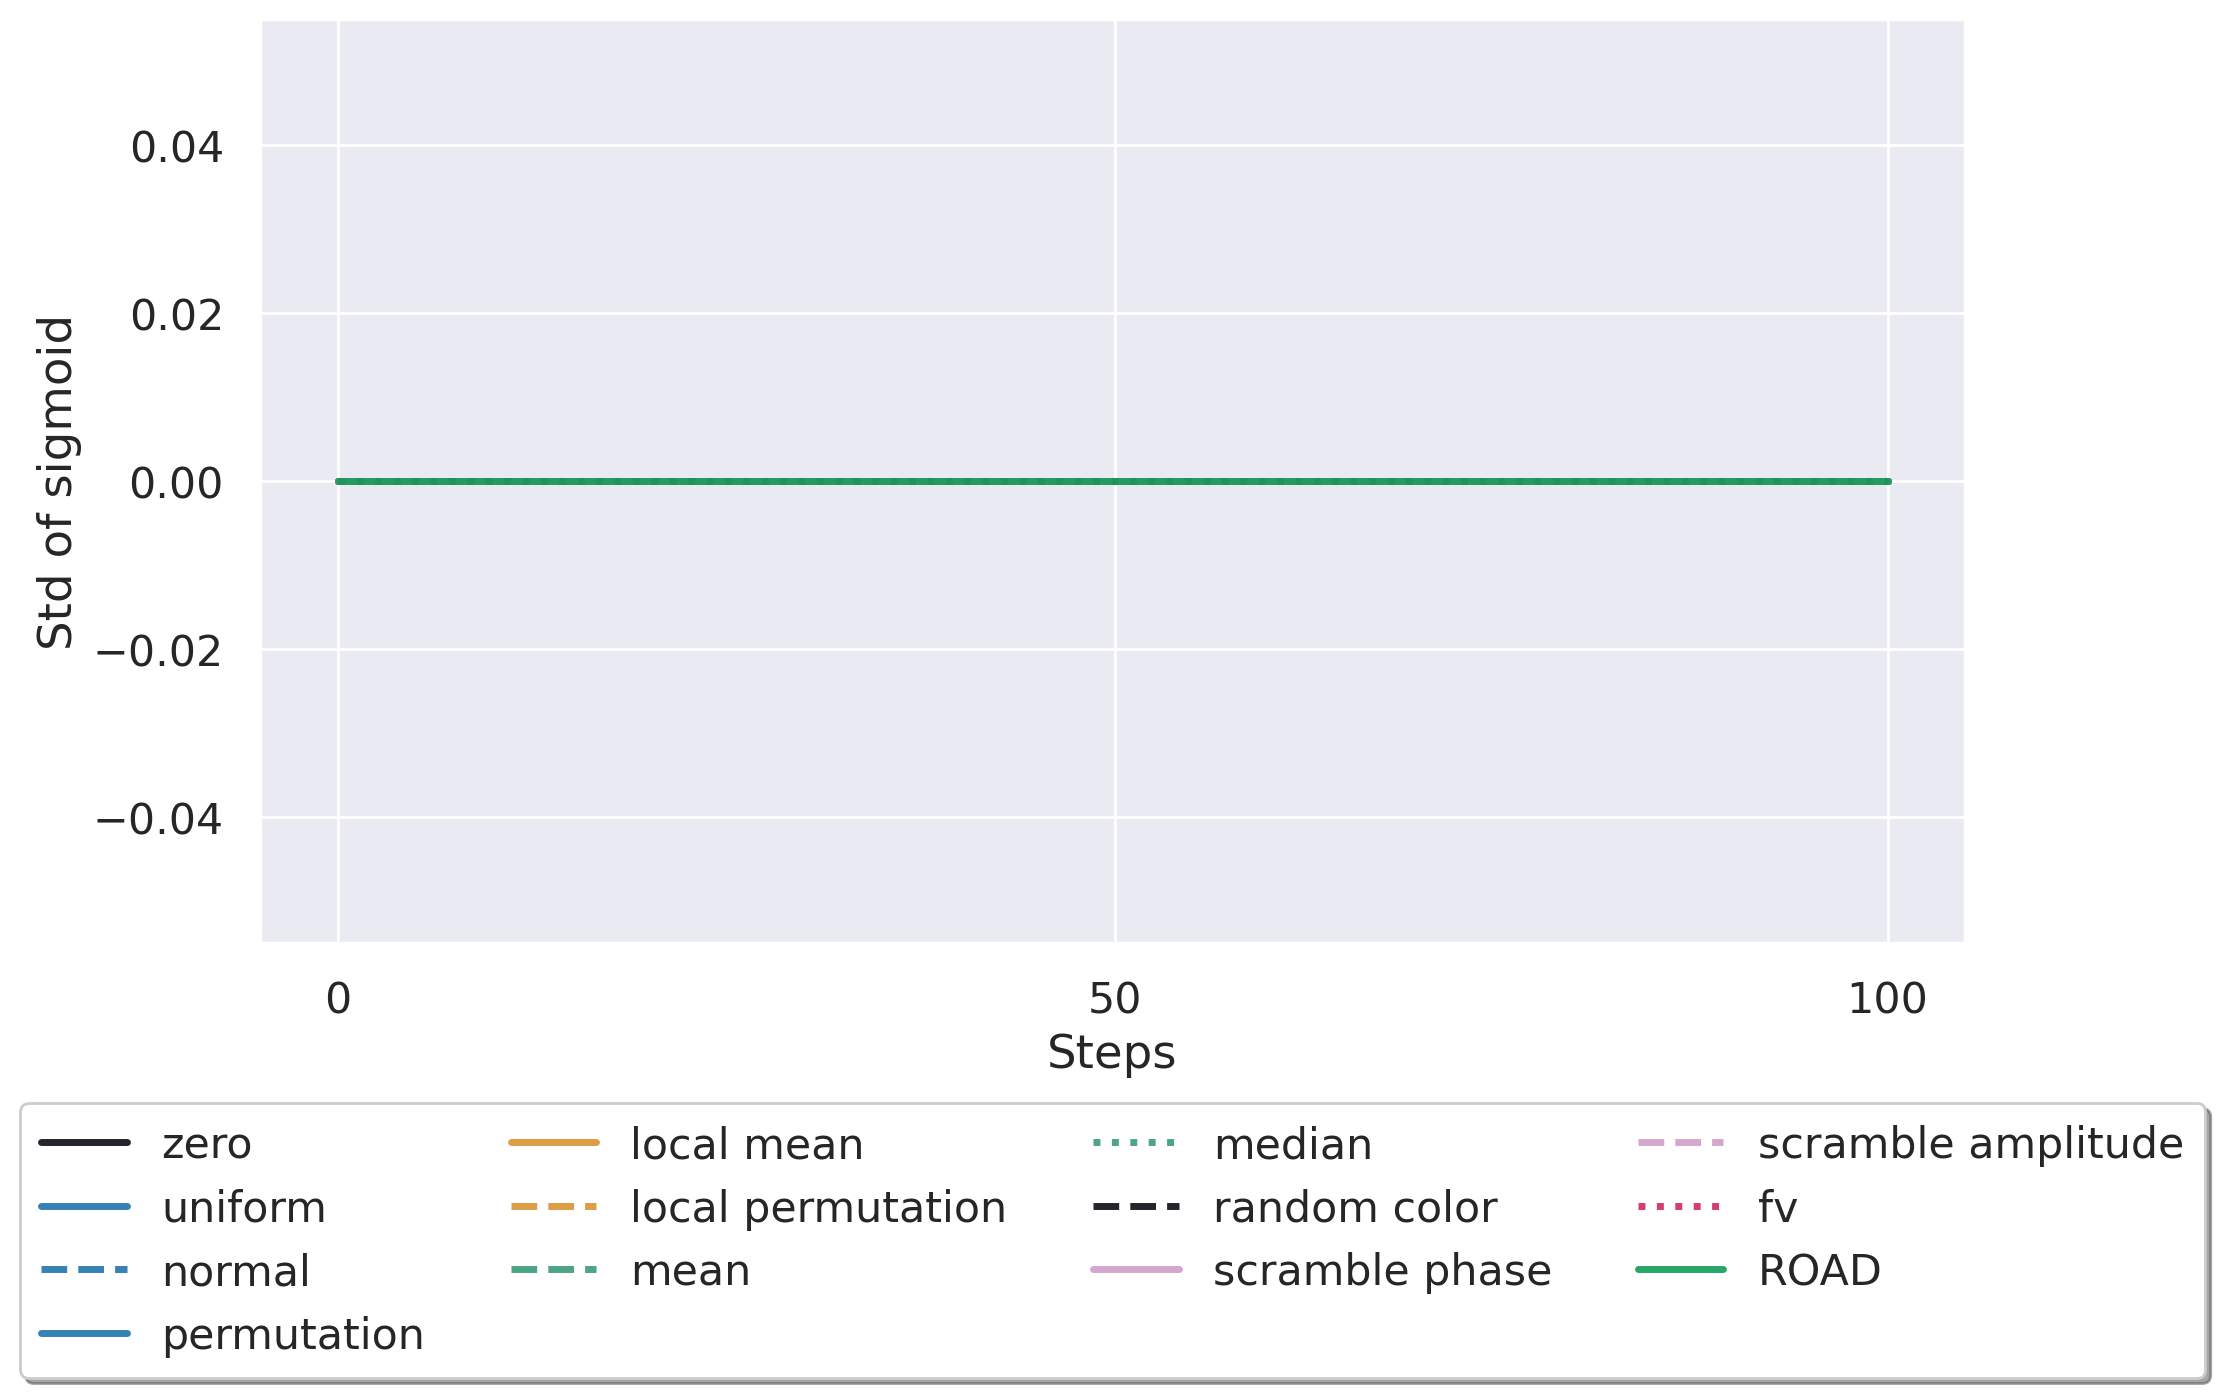

In [21]:
sns.set(font_scale=1.4)
set_size(11, 6)
cmap = plt.get_cmap('viridis')

lw = 2.5

for baseline in results:
  points = results[baseline]

  curve = [np.mean(p) for p in points][1:]
  stds = [np.std(p) for p in points][1:]

  color = baseline_to_color[baseline]
  ls = baseline_to_lstyle[baseline]

  xs, ys = poly_interp(stds, smooth=1.0)

  #plt.plot(curve, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)
  plt.plot(xs, ys, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.9, linestyle=ls)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')
plt.xticks([0, xs[len(xs)//2], xs[-1]], [0, 50, 100])
plt.xlabel("Steps")
plt.ylabel('Std of sigmoid')